In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
)
from src.plots.model_performance_per_participant import analyze_per_participant

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


In [3]:
FIGURE_DIR = Path("/Users/visser/drive/PhD/Papers/PAIN/figures")

In [4]:
config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
stimulus_seeds = config["stimulus"]["seeds"]
print(f"Using seeds for stimulus generation: {stimulus_seeds}")

Using seeds for stimulus generation: [133, 243, 265, 396, 467, 658, 681, 743, 806, 841, 870, 952]


In [5]:
# Load model
model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-150402.pt"  # 7 s with plateaus, 0.77, very nice
        # "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250804-180810.pt" # replication
        "results/experiment_eda_raw_pupil_mean/model/PatchTST_20250806-185235.pt"
    )
)

19:02:01 | INFO    | utils | Using device: mps
19:02:01 | INFO    | utils | Loaded PatchTST model with test accuracy 0.74 to mps
19:02:01 | INFO    | utils | Input shape: (70, 2) | Features: ['eda_raw', 'pupil_mean'] | Sample duration: 7000 ms
19:02:01 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
19:02:01 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
19:02:01 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}


In [6]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

# Get particpant IDs from test set
test_groups = prepare_data(
    df,
    feature_list,
    sample_duration_ms,
    RANDOM_SEED,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    only_return_test_groups=True,
)
test_ids = np.unique(test_groups)

19:02:01 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points


In [7]:
# Get participant leaderboard
# = a list of participant IDs in the test set, sorted by their accuracy on the test set, from highest to lowest.

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df,
    feature_list,
    sample_duration_ms,
    RANDOM_SEED,
    intervals,
    label_mapping,
    offsets_ms,
)

_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)

results_df = analyze_per_participant(
    model,
    test_loader,
    test_groups,
    threshold=0.50,
)

leaderboard = (
    results_df.remove(participant="overall")
    .sort("accuracy", descending=True)
    .get_column("participant")
    .to_list()
)
leaderboard

19:02:02 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
19:02:02 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 1337
19:02:02 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
19:02:02 | DEBUG   | data_preparation | Offsets for intervals: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
19:02:02 | DEBUG   | data_preparation | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
19:02:02 | INFO    | data_preparation | Number of unique participants in training set: 24
19:02:02 | INFO    | data_preparation | Number of unique participants in validation set: 9
19:02:02 | INFO    | data_preparation | Number of unique participants in test set: 9
19:02:02 | DEBUG   | data_preparation | Participant IDs in test set: [ 1  8 10 16 17 20 24 36 37]
19:02:02 | DEBUG   | data_l

['20', '16', '37', '8', '17', '36', '24', '10', '1']

In [8]:
["20", "16", "37", "24", "36", "17", "10", "8", "1"]

['20', '16', '37', '24', '36', '17', '10', '8', '1']

In [9]:
# Analyze the entire test dataset
all_probabilities = {}
all_participant_trials = {}

for stimulus_seed in stimulus_seeds:
    probabilities, participant_trials = analyze_test_dataset_for_one_stimulus(
        model, db, feature_list, test_ids, stimulus_seed, sample_duration_ms, log=True
    )

    all_probabilities[stimulus_seed] = probabilities
    all_participant_trials[stimulus_seed] = participant_trials


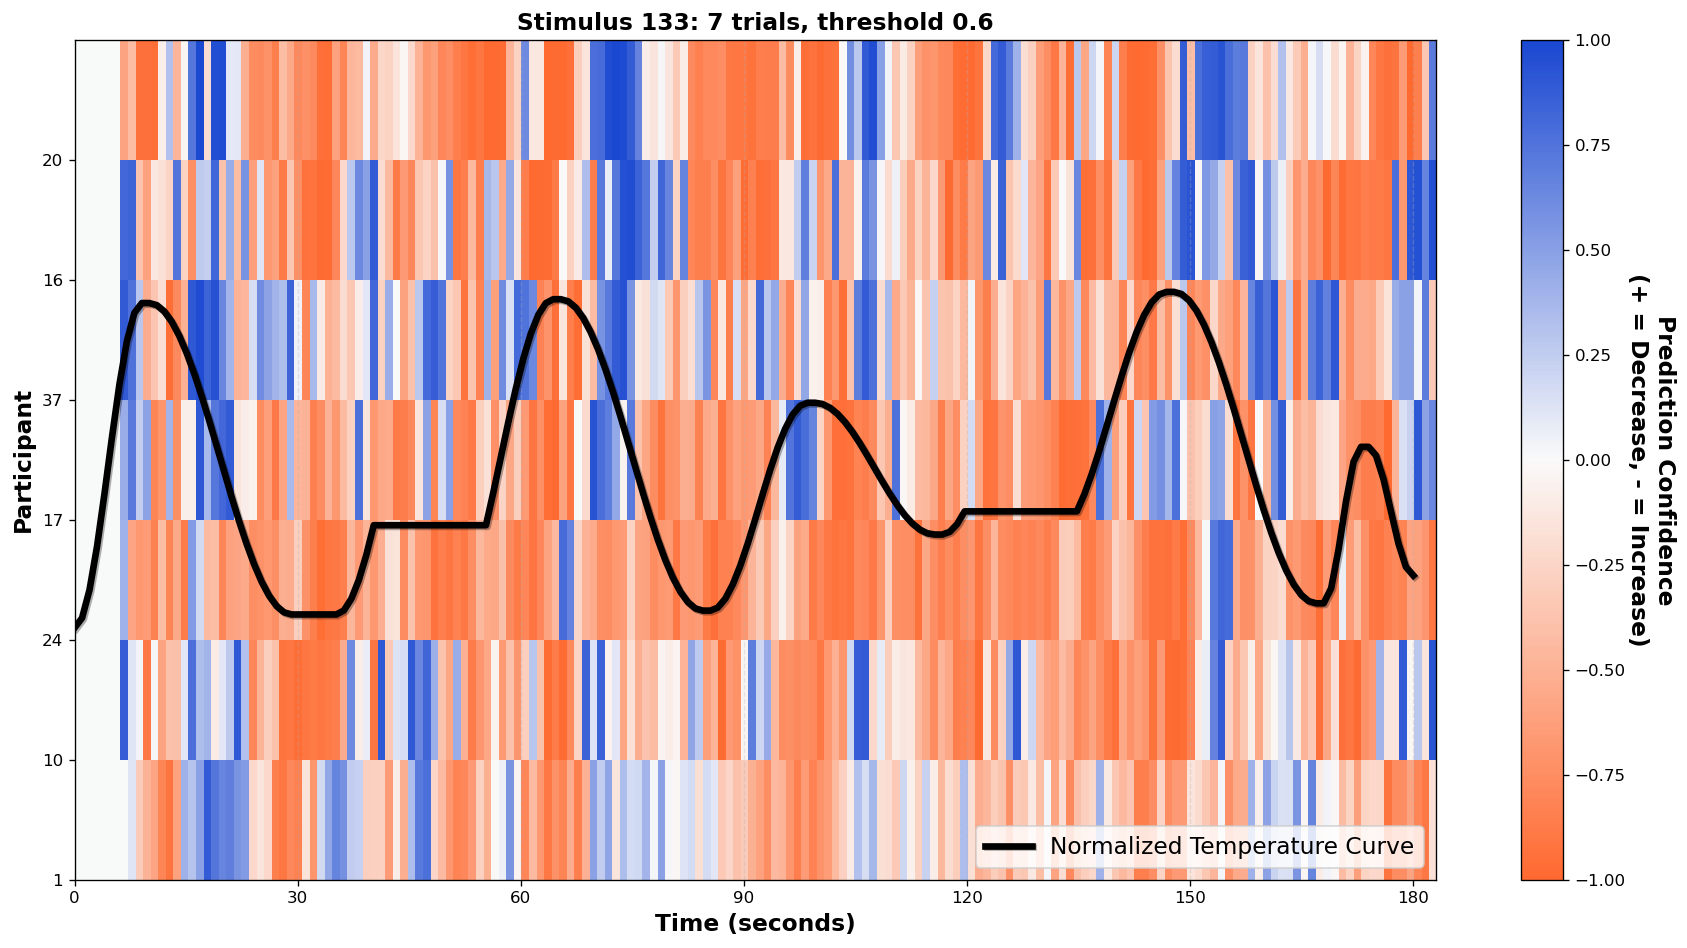

In [25]:
stimulus_seed = stimulus_seeds[0]
threshold = 0.6

a = plot_prediction_confidence_heatmap(
    probabilities=all_probabilities[stimulus_seed],
    stimulus_seed=stimulus_seed,
    classification_threshold=threshold,
    sample_duration=sample_duration_ms,
    leaderboard=leaderboard,
)

![alt text](346546c3-4f9a-4c21-88da-582c5ac04e70.png)

7 s with plateeaus
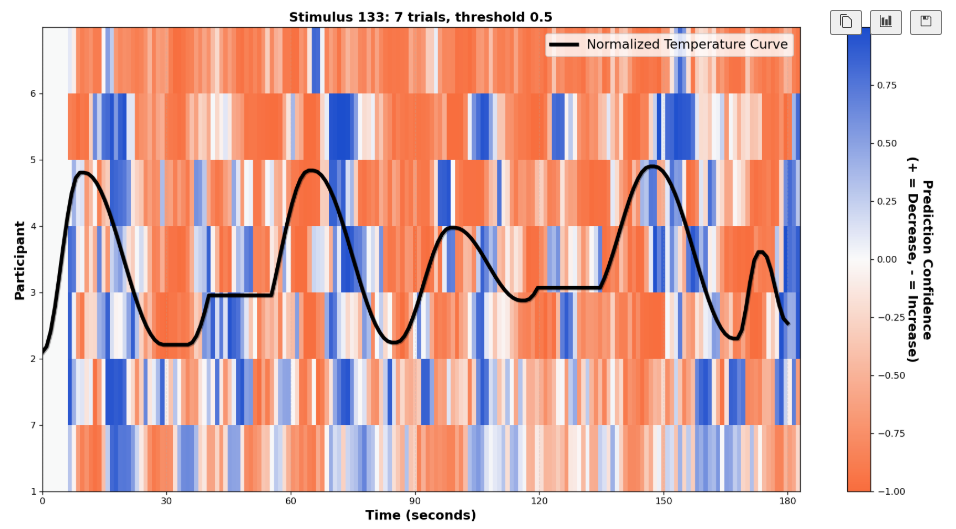

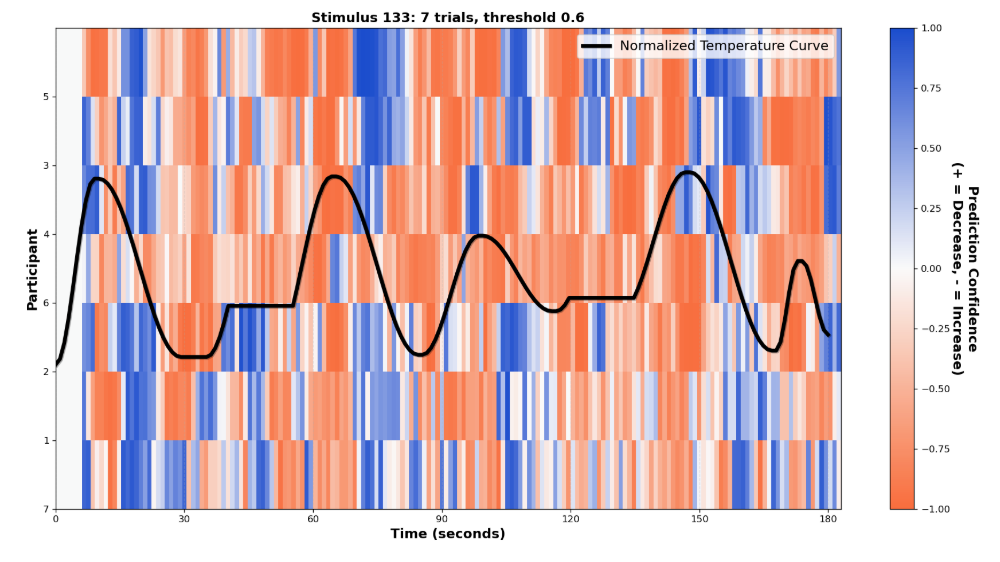

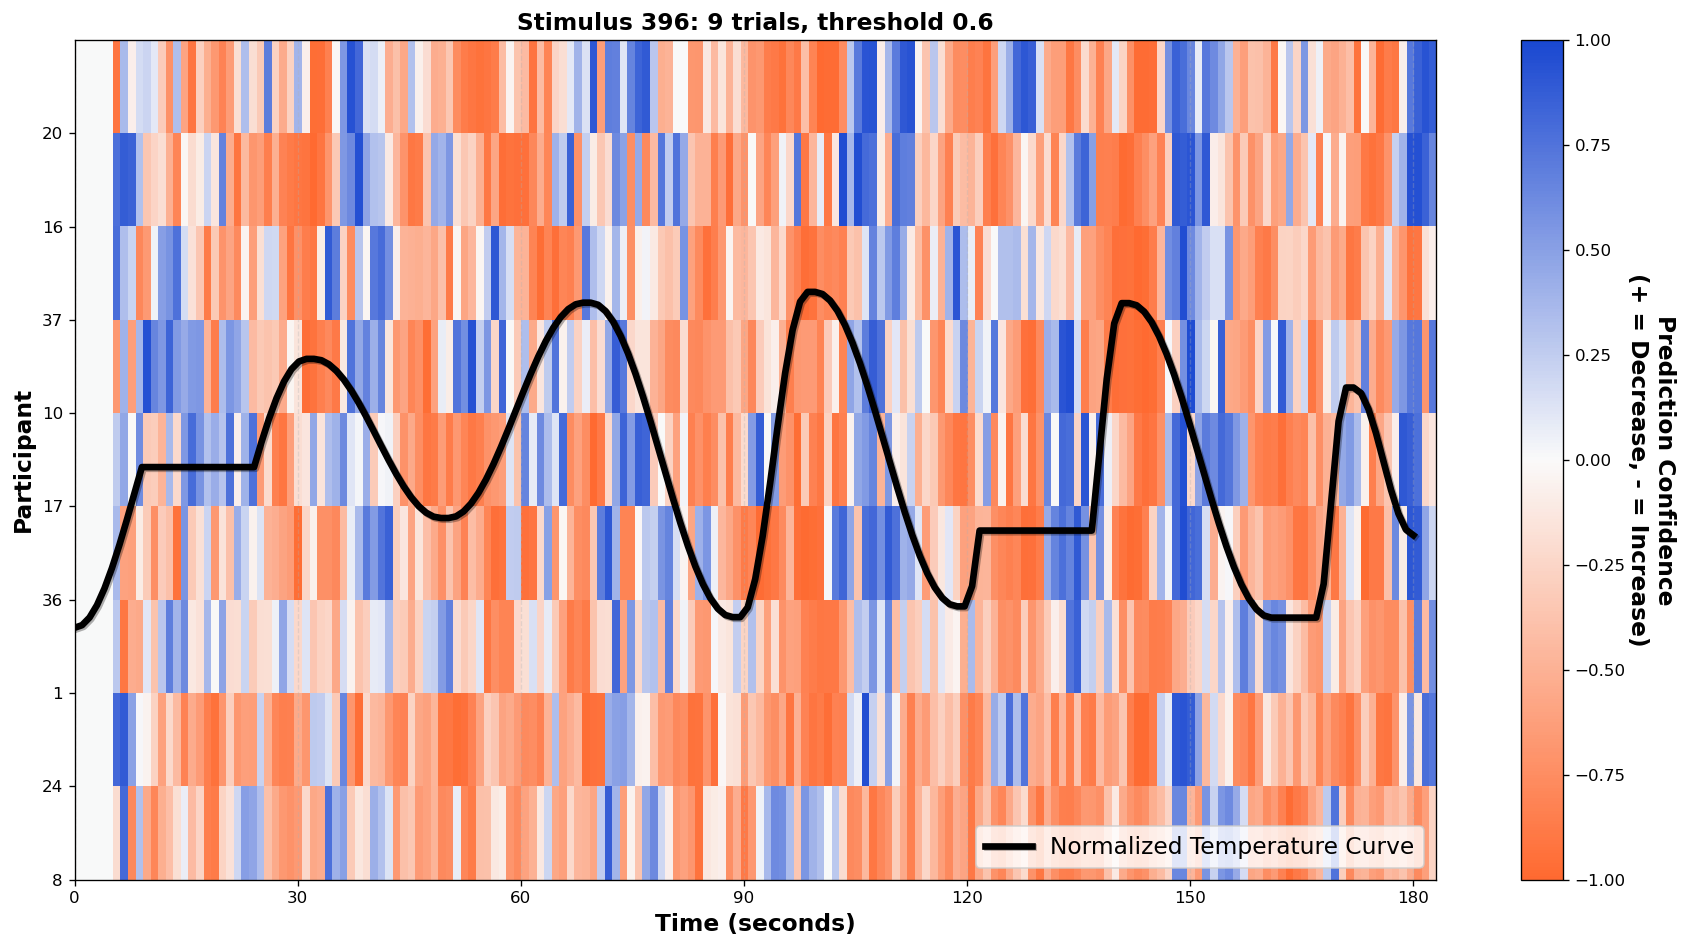

In [24]:
stimulus_seed = 396
threshold = 0.6

a = plot_prediction_confidence_heatmap(
    probabilities=all_probabilities[stimulus_seed],
    stimulus_seed=stimulus_seed,
    classification_threshold=threshold,
    sample_duration=sample_duration_ms,
    leaderboard=leaderboard,
)

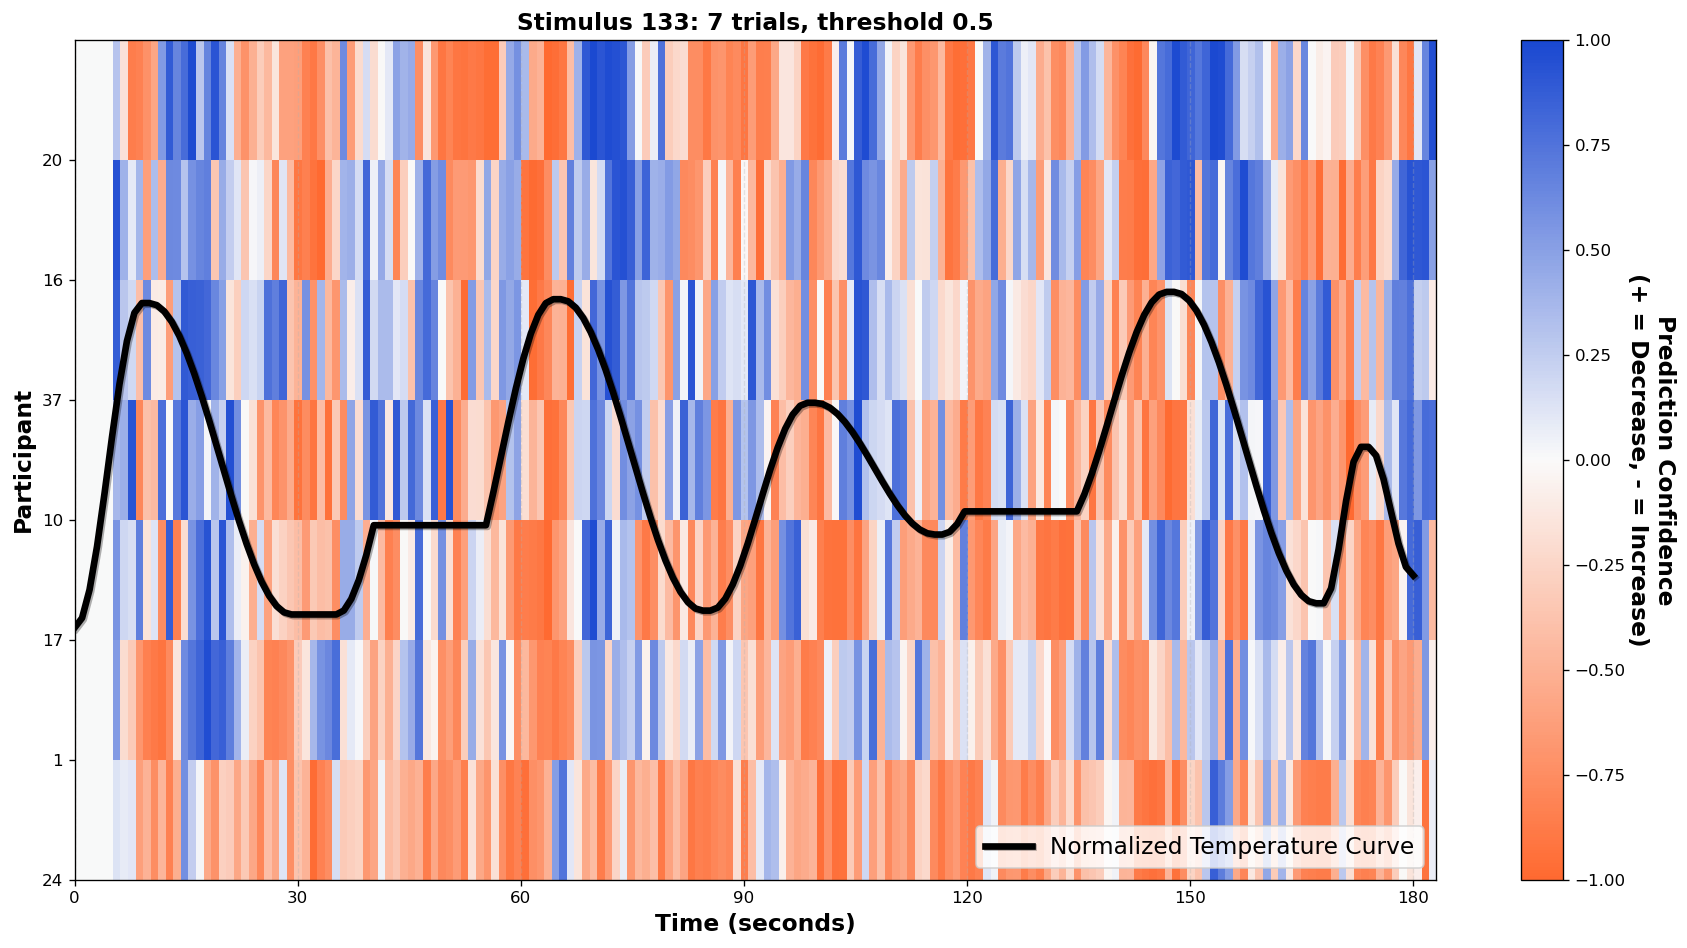

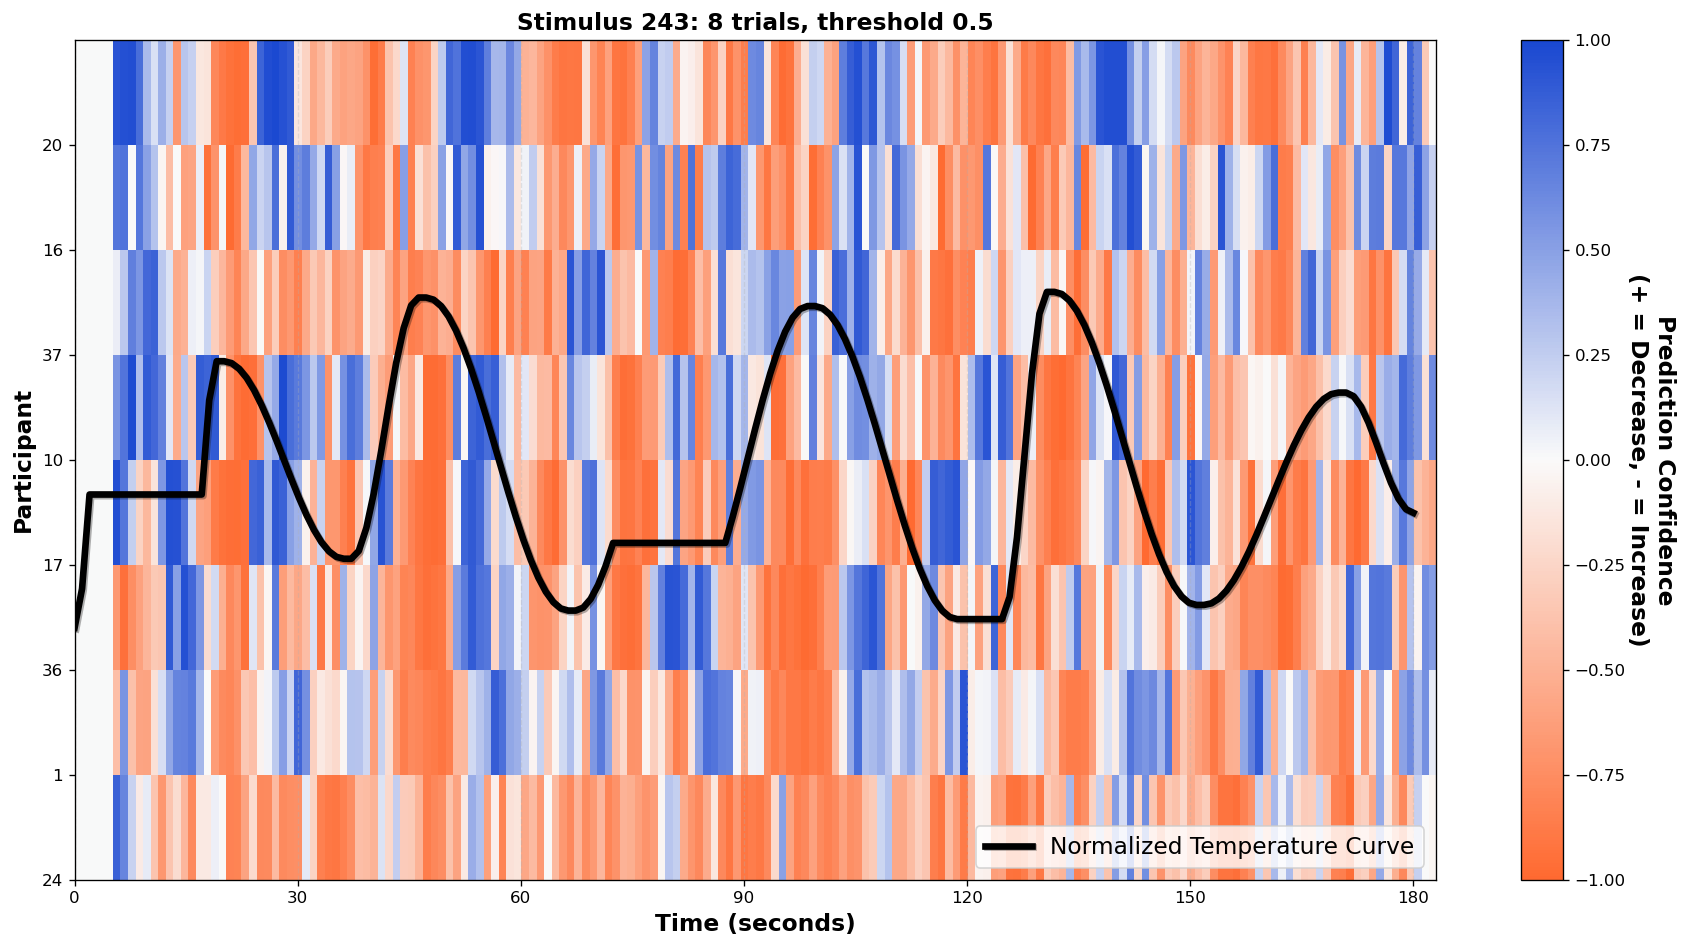

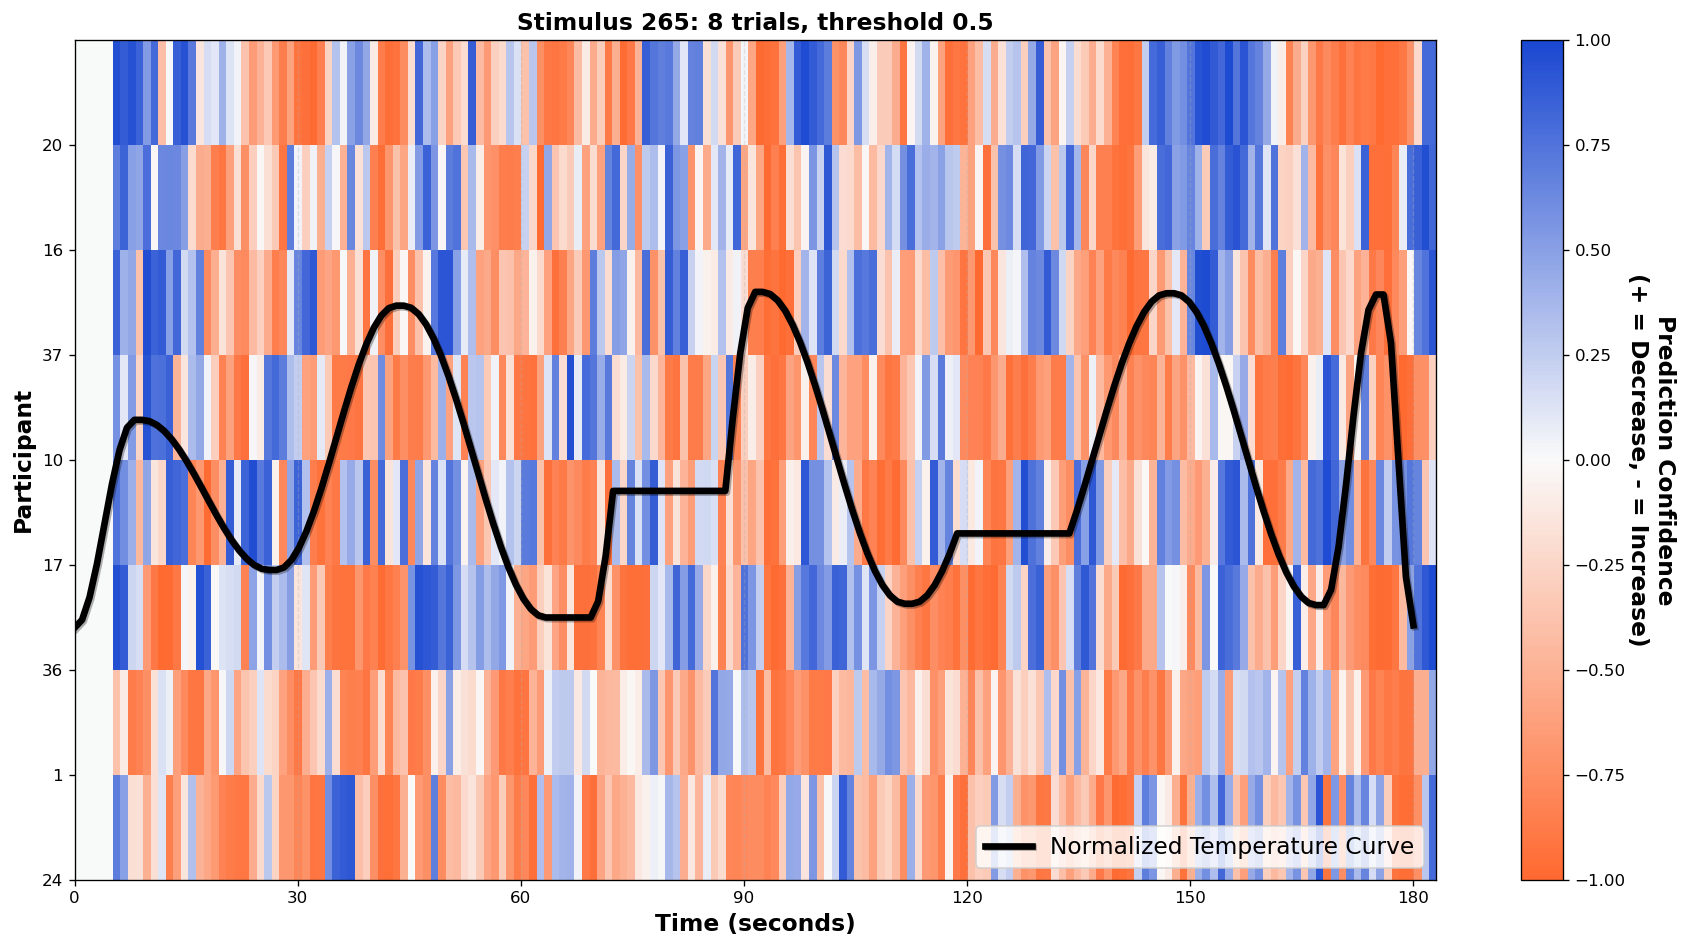

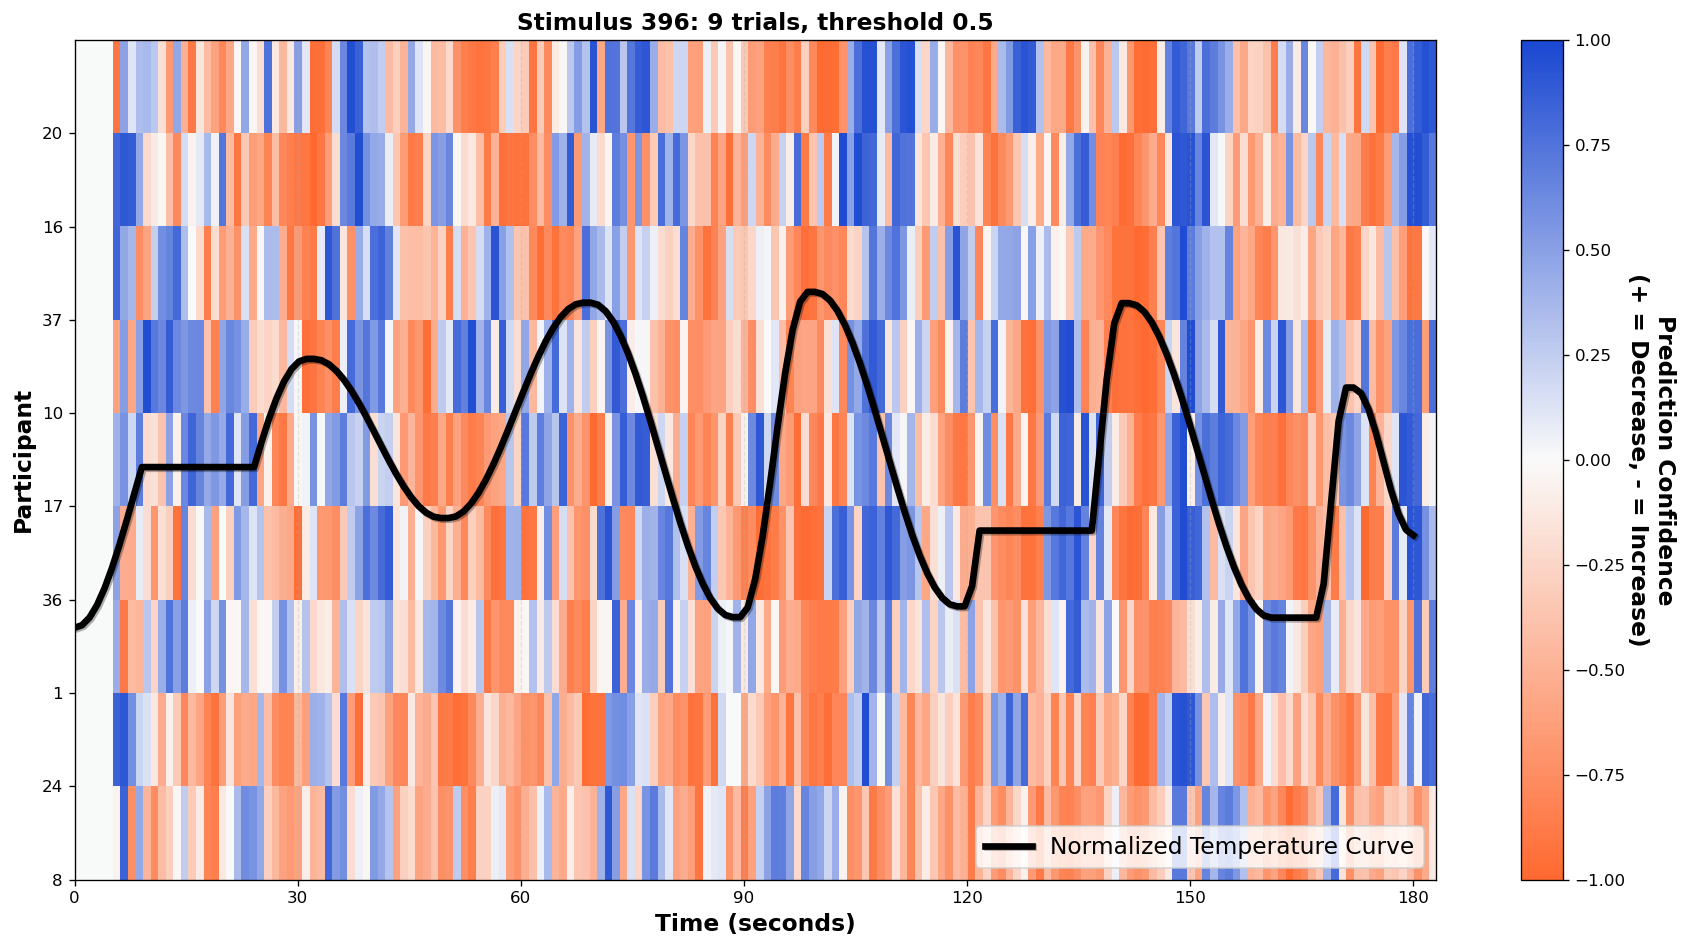

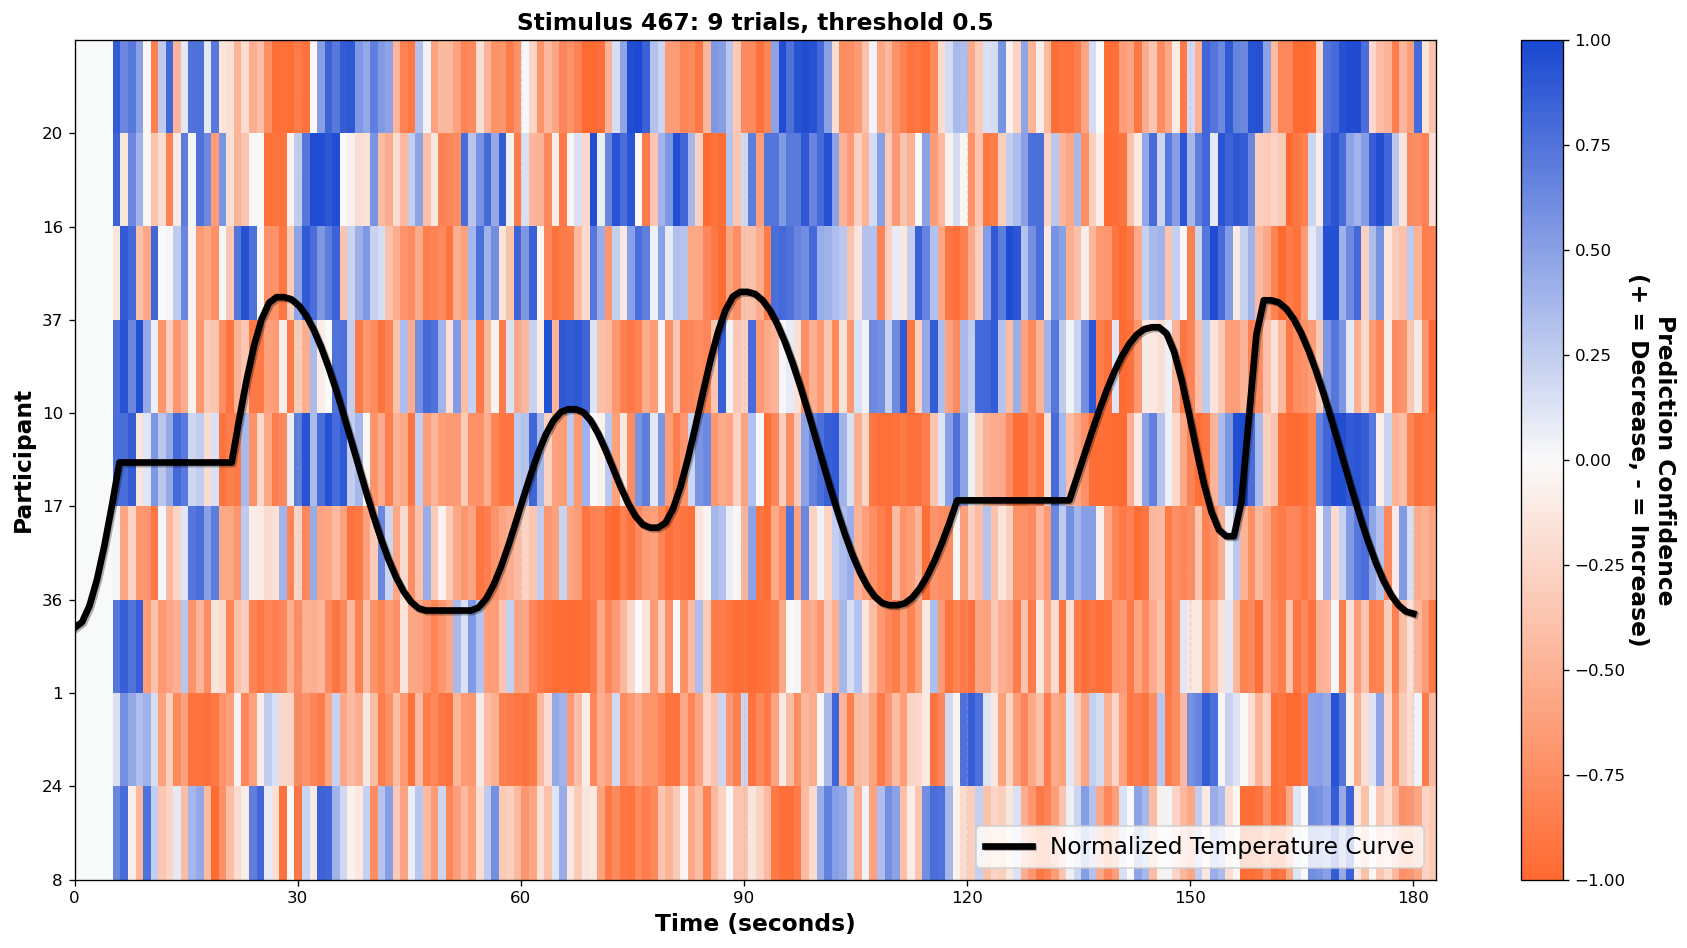

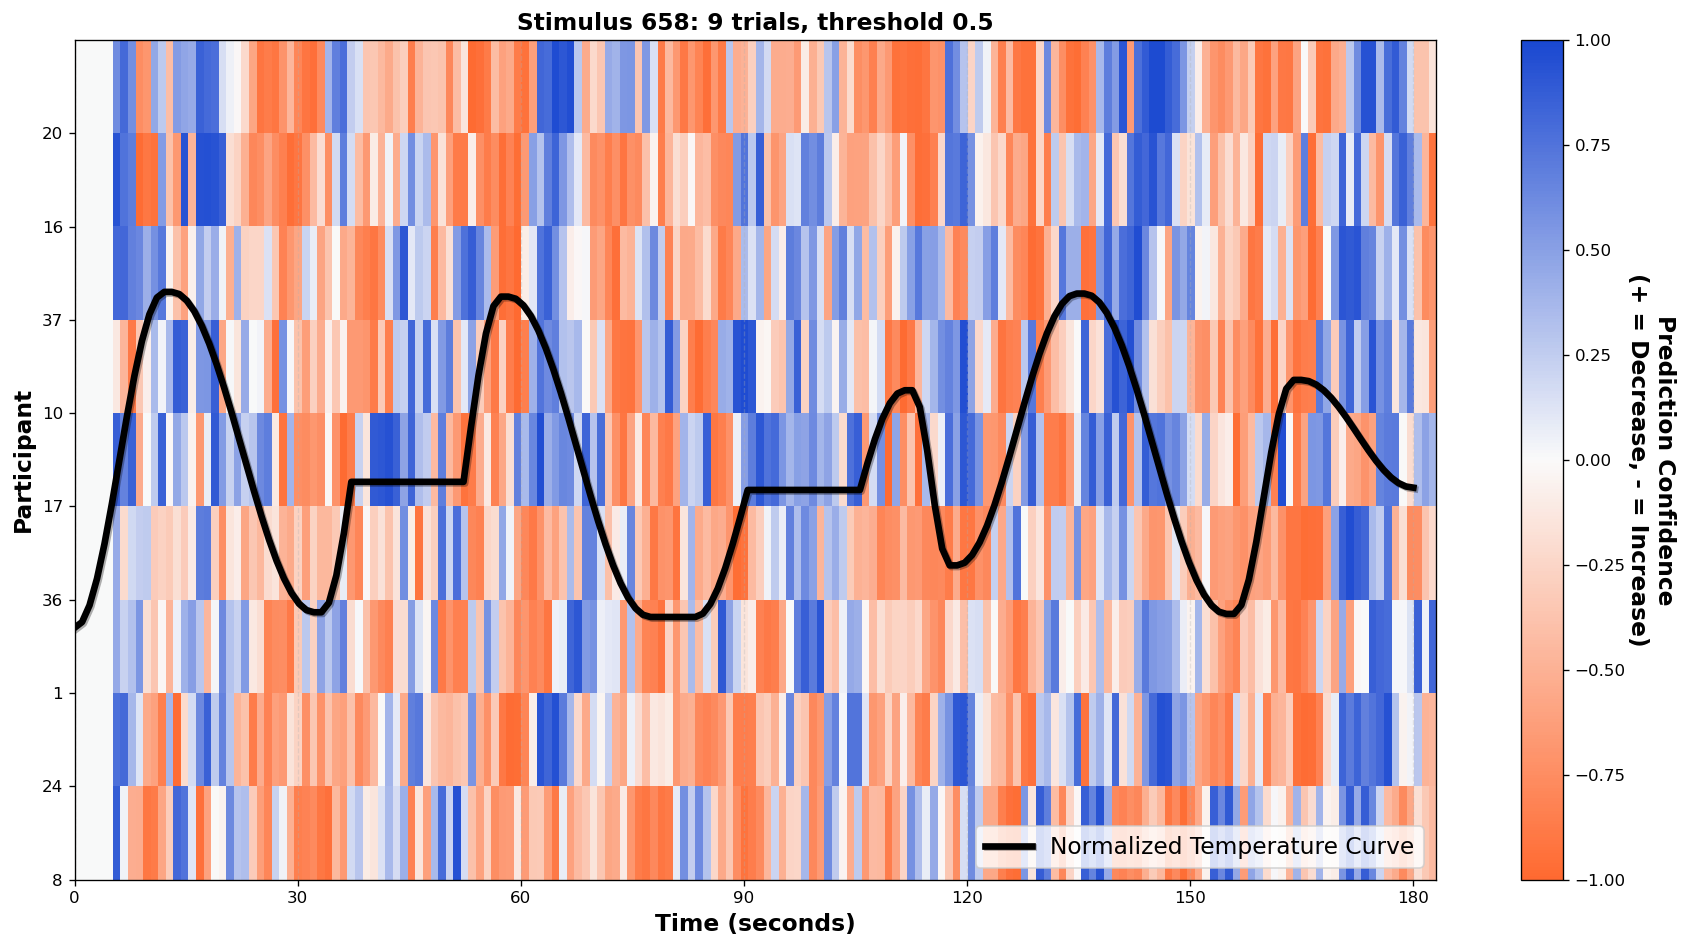

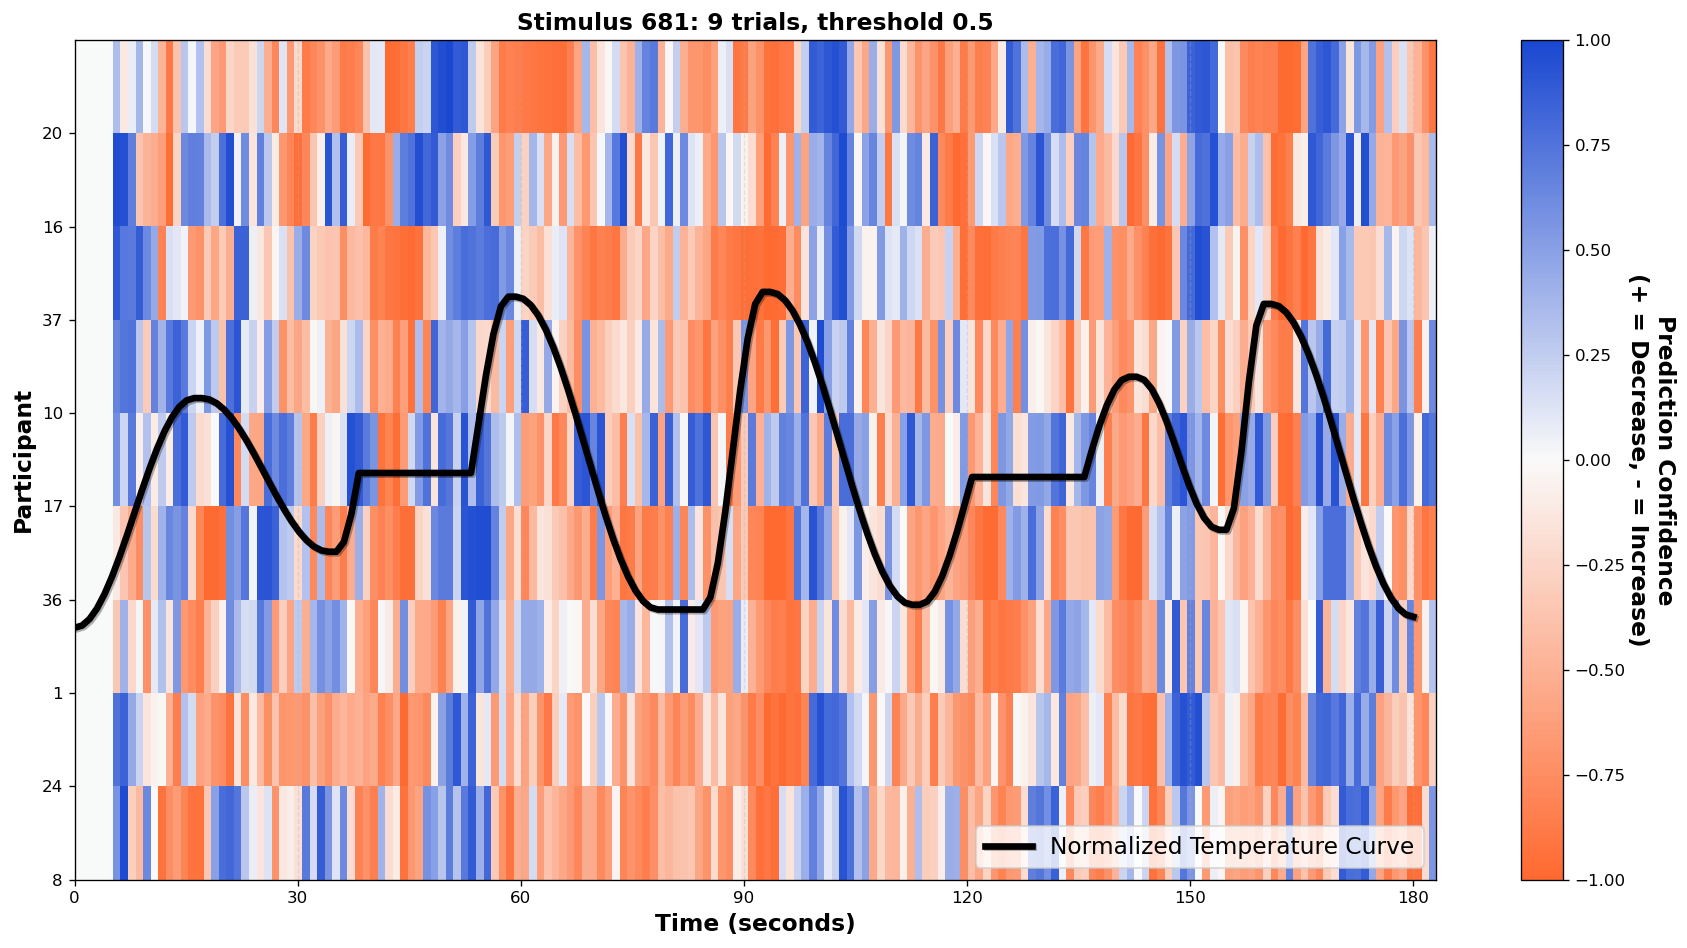

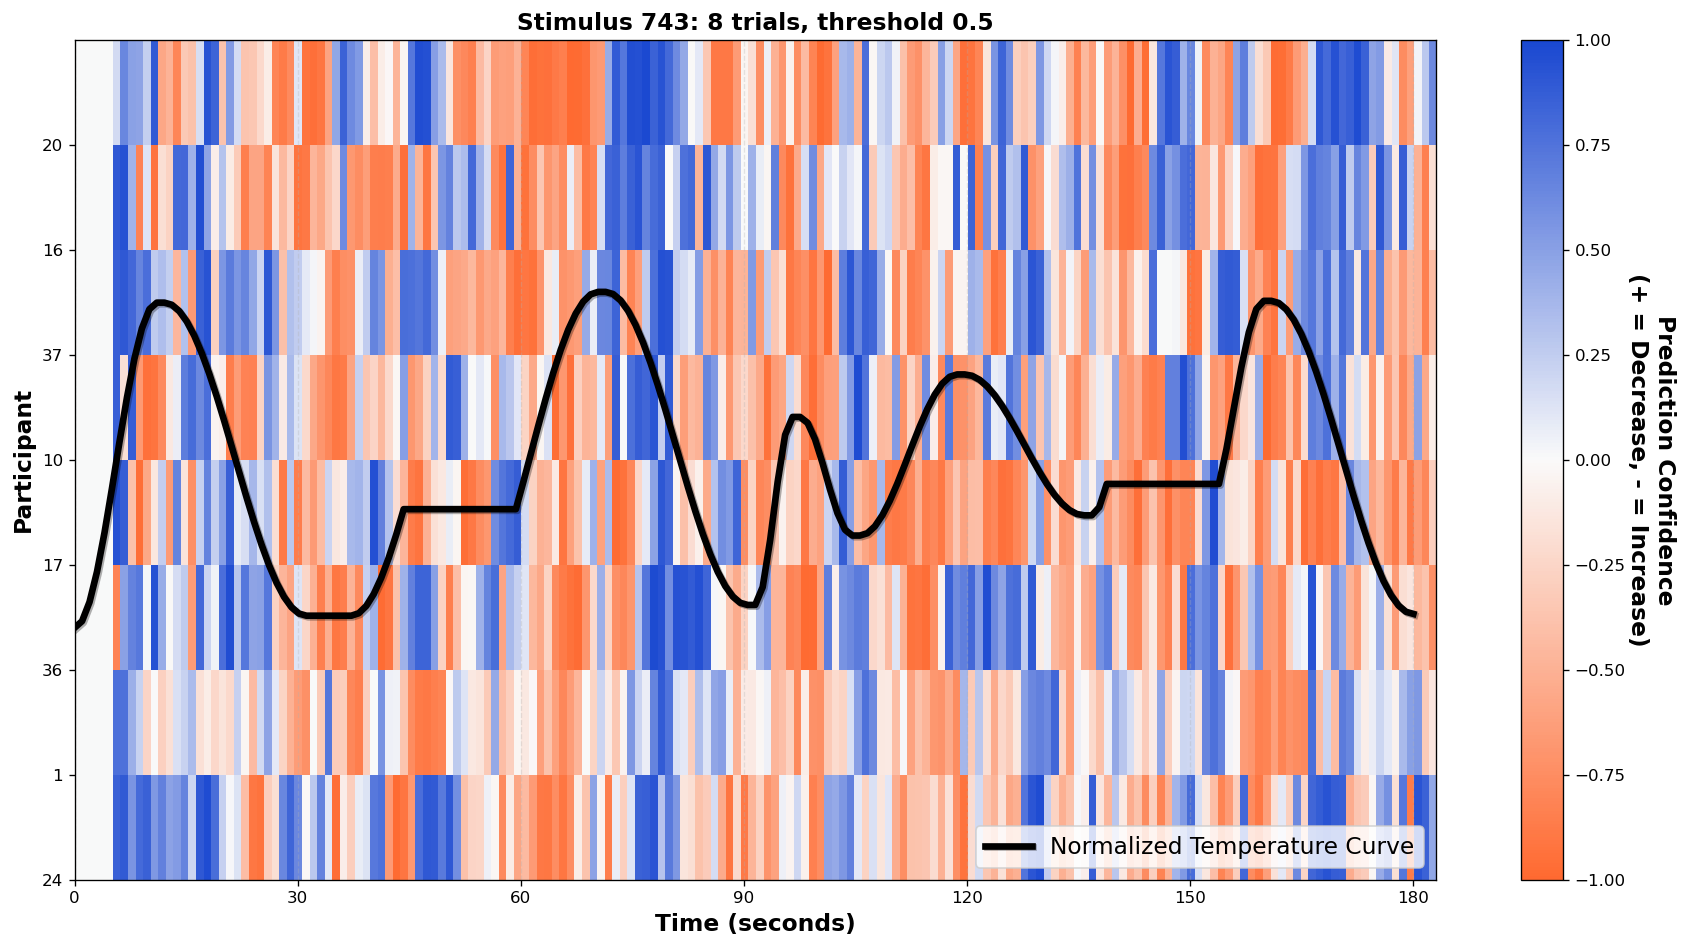

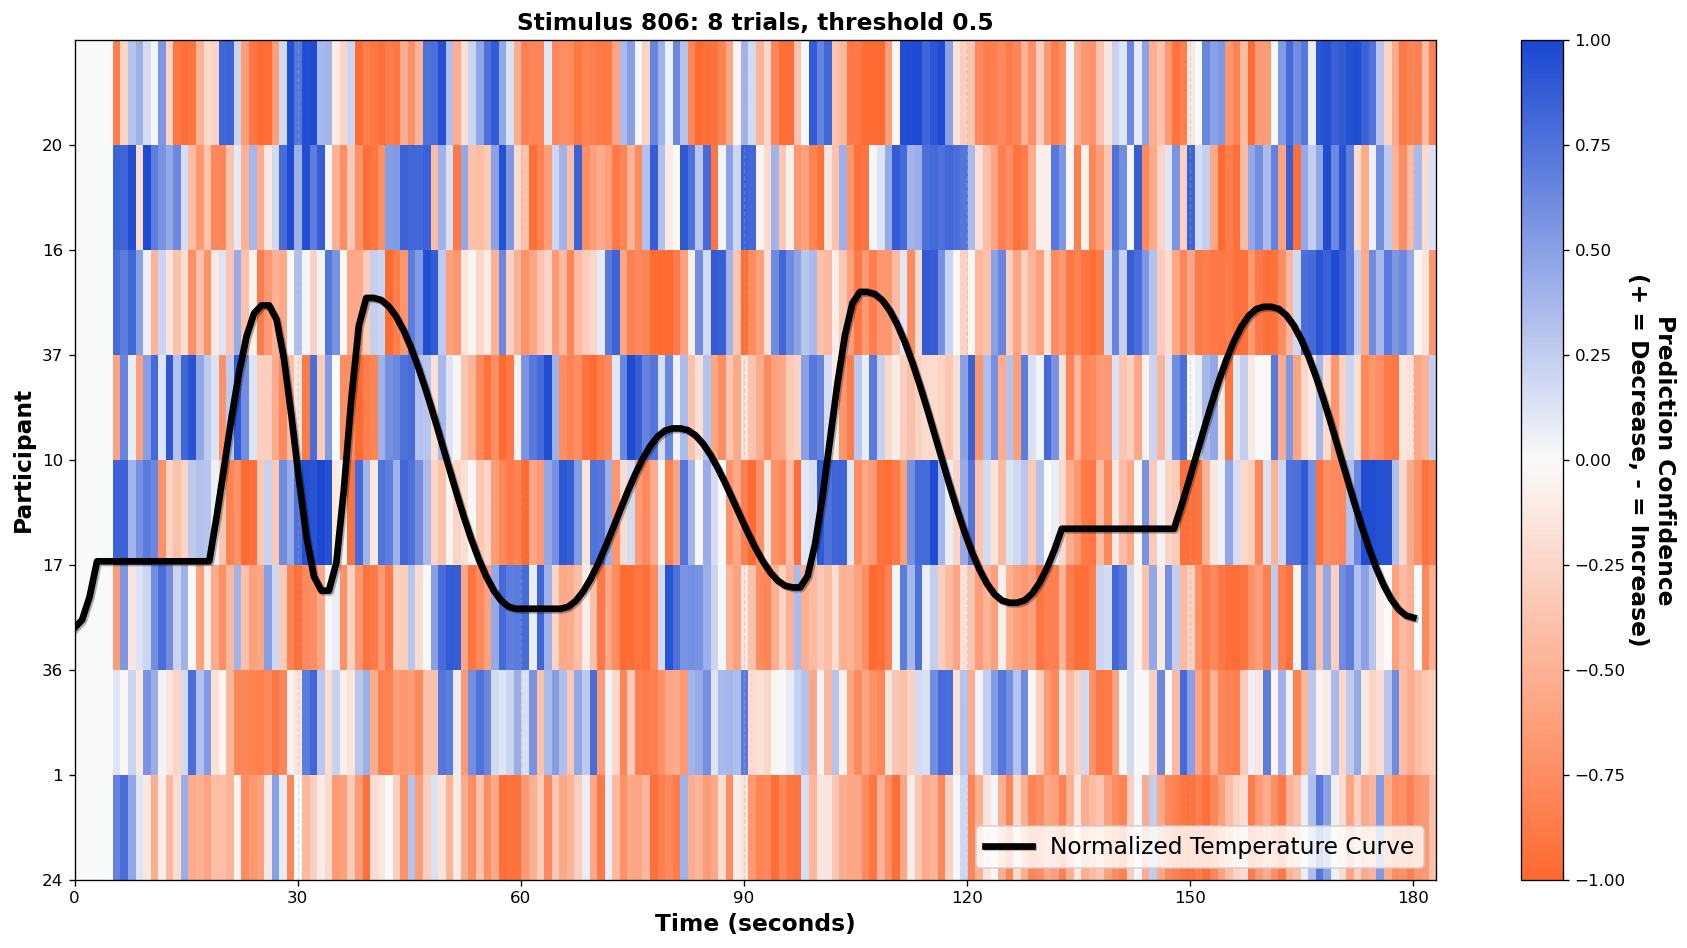

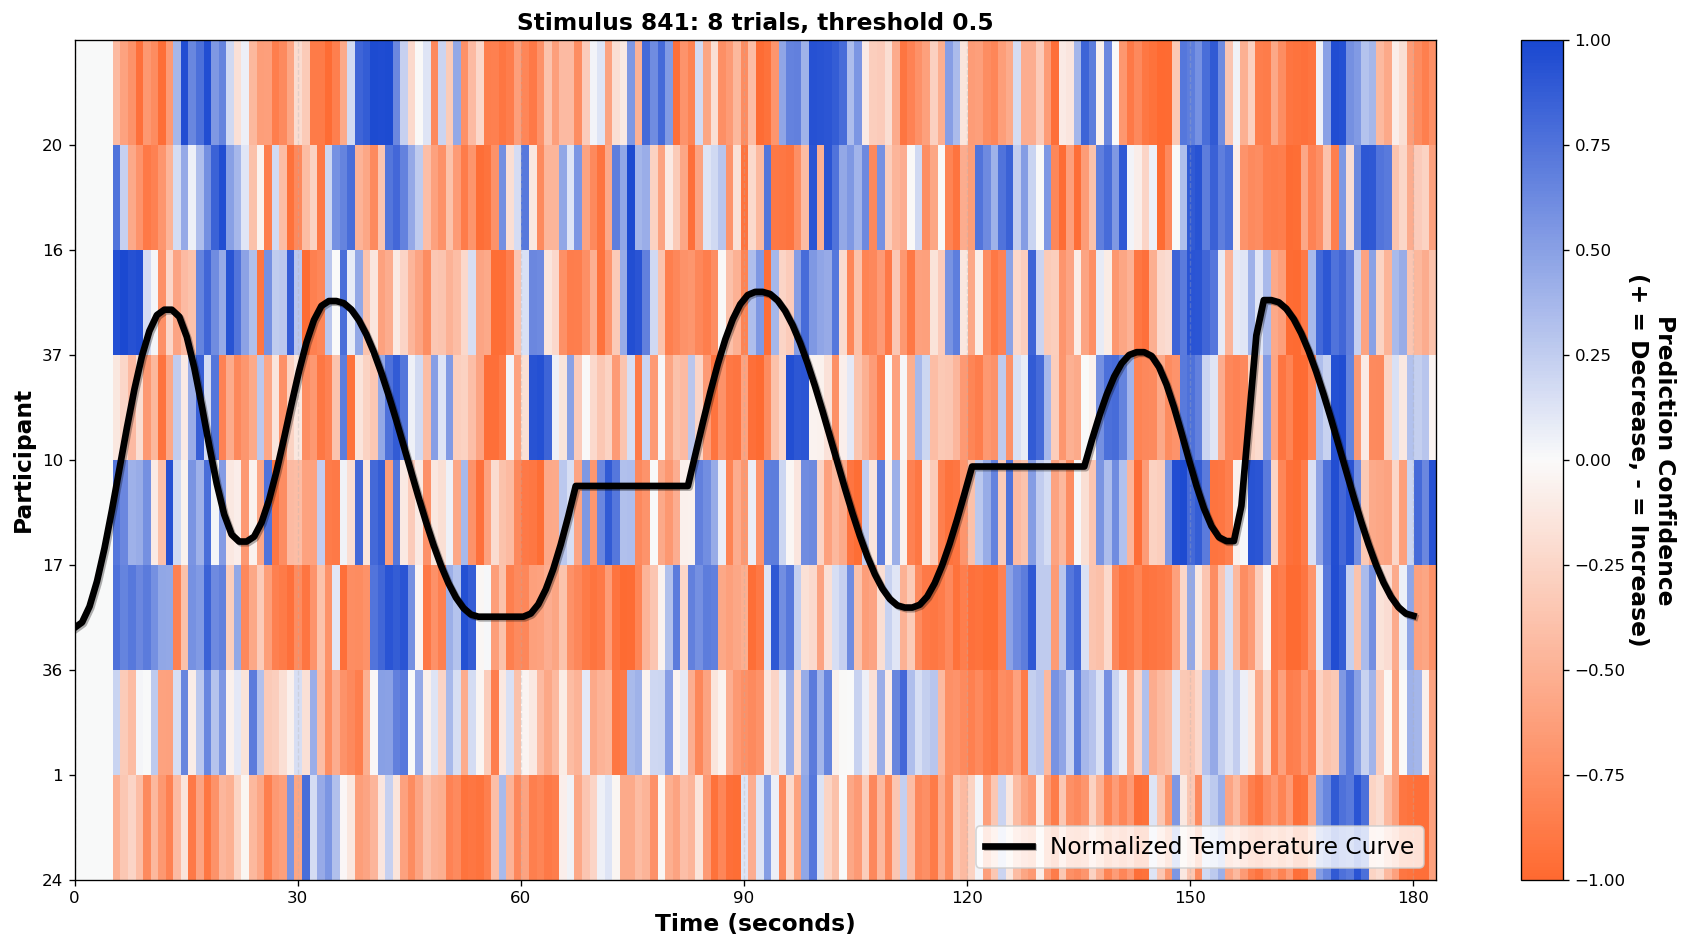

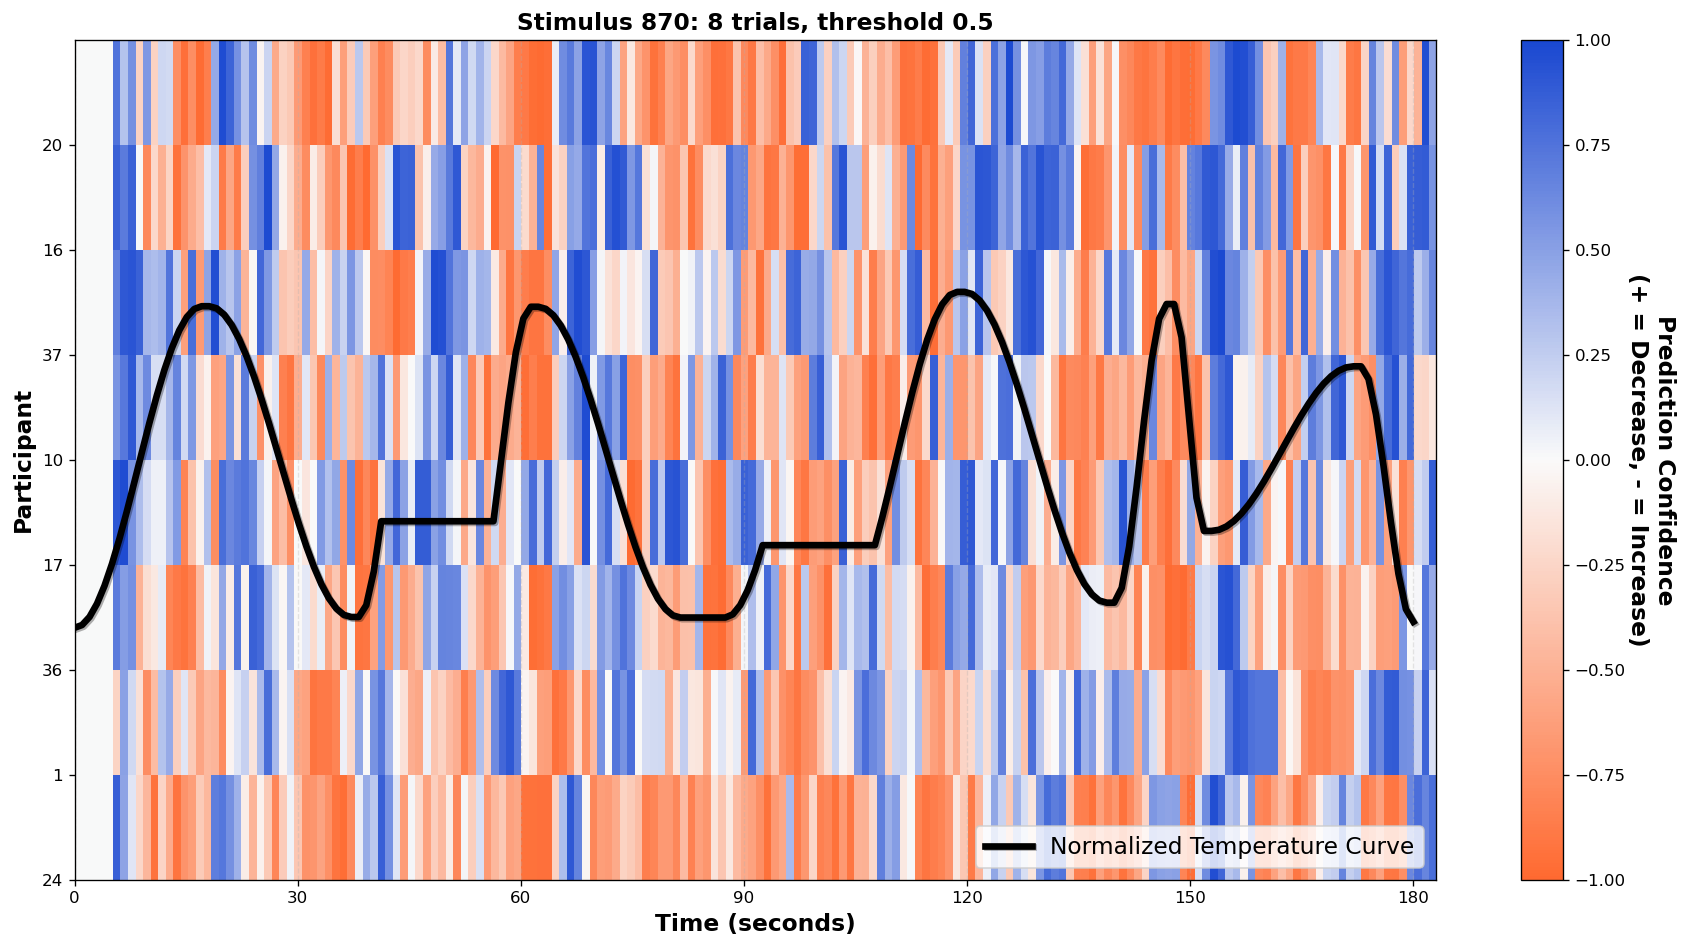

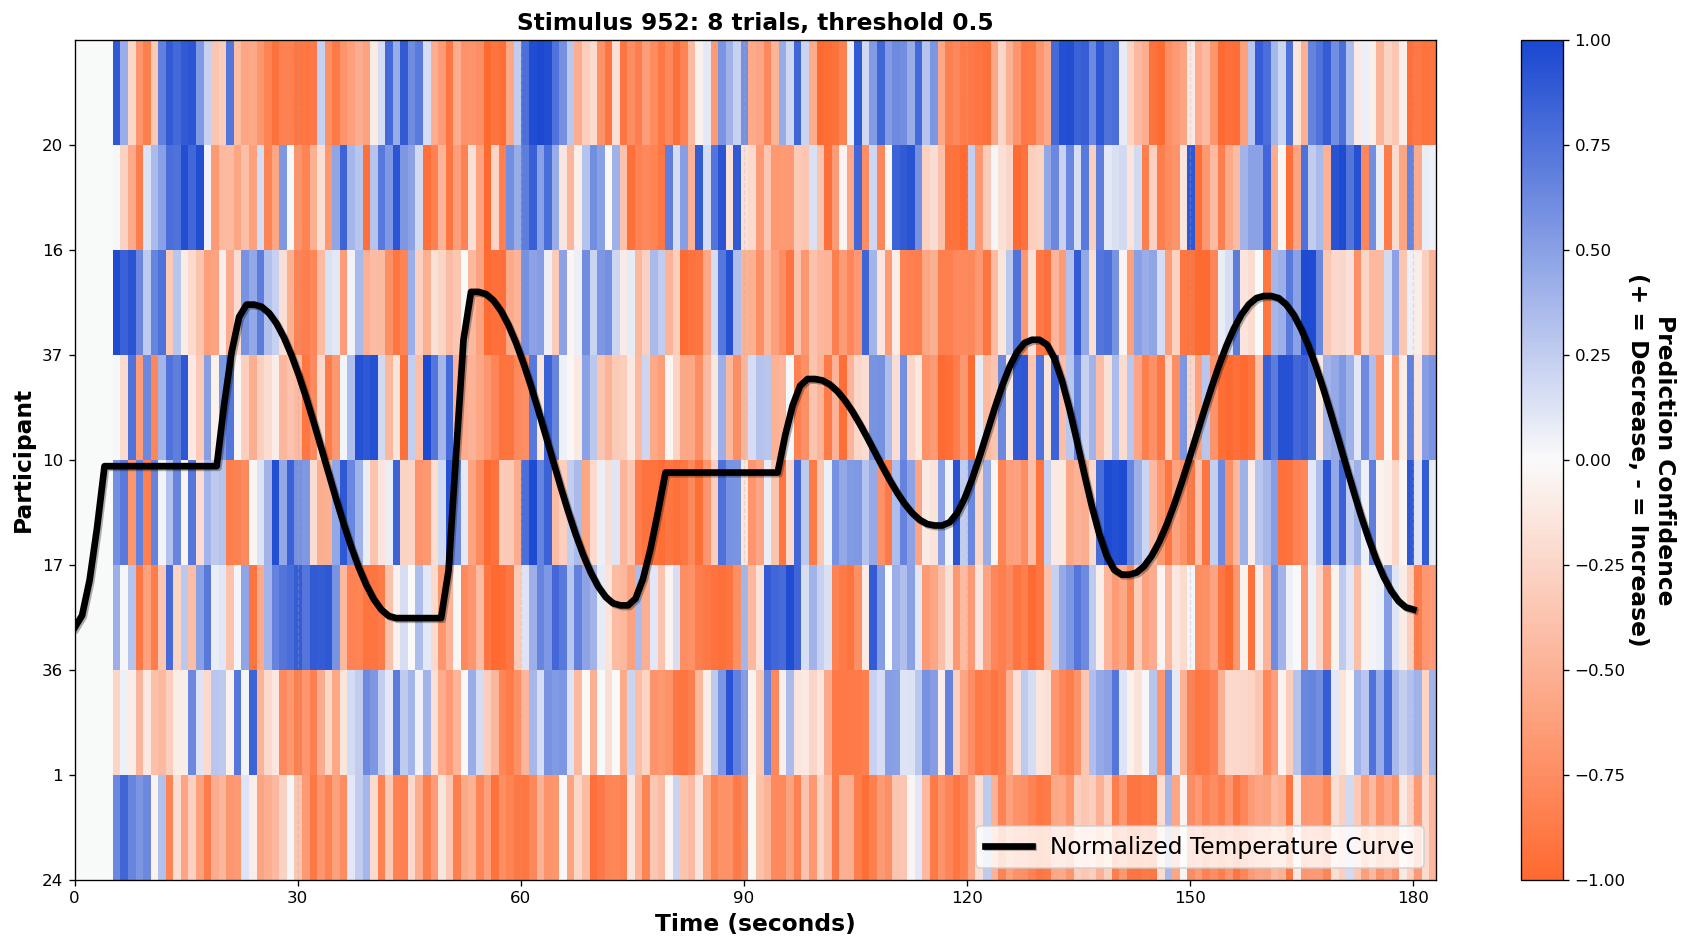

In [25]:
threshold = 0.5

for stimulus_seed in stimulus_seeds:
    # Create the visualization
    plot_prediction_confidence_heatmap(
        probabilities=all_probabilities[stimulus_seed],
        stimulus_seed=stimulus_seed,
        classification_threshold=threshold,
        sample_duration=sample_duration_ms,
        leaderboard=leaderboard,
    )